In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install darts --quiet

import darts
print(f"Darts version: {darts.__version__}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.8/784.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 k

In [ ]:
import pandas as pd

# Load a sample time series dataset
# Skip the first 2 rows when reading the CSV
df = pd.read_csv("ice_cream.csv", header=1, names=['Month', 'ice_cream'])
print(df.shape)
df.head()

(235, 2)


Month  ice_cream
0  2004-01       12.0
1  2004-02       13.0
2  2004-03       14.0
3  2004-04       16.0
4  2004-05       20.0

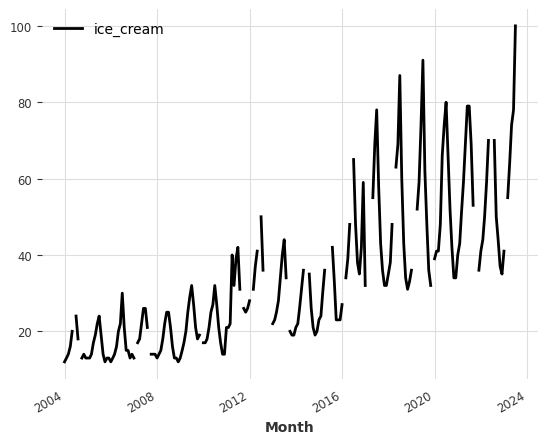

In [ ]:
from darts import TimeSeries
series = TimeSeries.from_dataframe(df, 'Month', 'ice_cream')
series.plot()

In [ ]:
from darts.utils.missing_values import fill_missing_values
series = fill_missing_values(series)

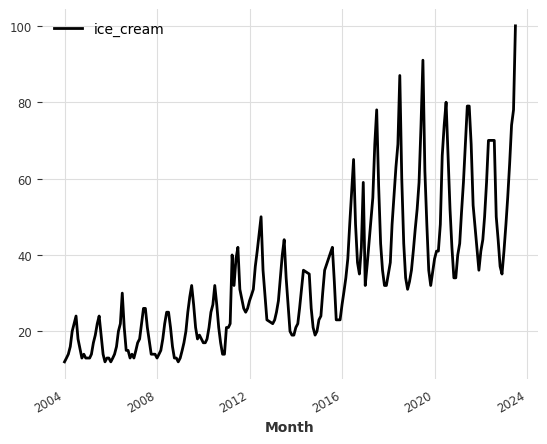

In [ ]:
series.plot()

Easy! What if we want to plot our data on an annual basis instead? We can just resample!

In [ ]:
# Resampling and frequency conversion
resampled_example = series.resample("Y")

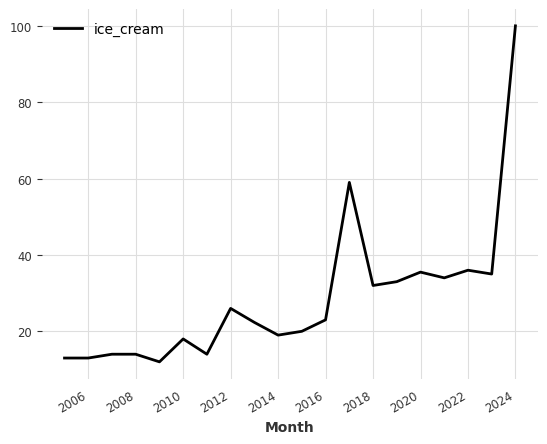

In [ ]:
resampled_example.plot()

In [ ]:
# Applying rolling window calculations
rolling_mean_example = series.window_transform({"function":"mean", "window": 6})

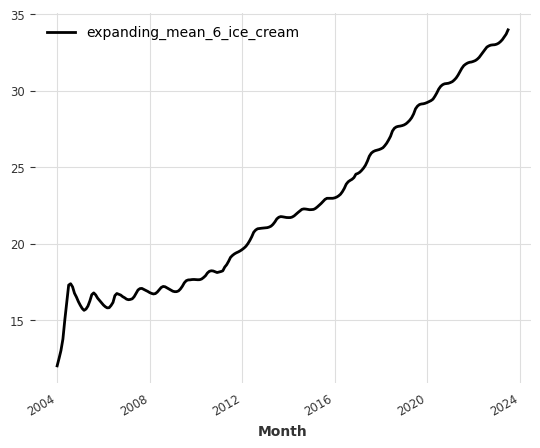

In [ ]:
rolling_mean_example.plot()

We can diff our series just like we did with Pandas earlier

In [ ]:
# Feature engineering
diff_example = series.diff()

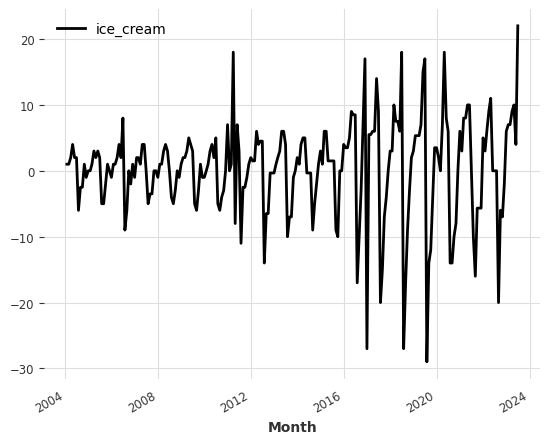

In [ ]:
diff_example.plot()

In [ ]:
hol_example = series.add_holidays("US")

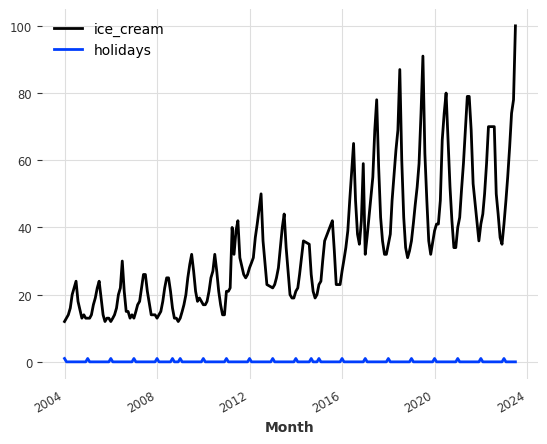

In [ ]:
hol_example.plot()

In [ ]:
import numpy as np
logged = (series).map(lambda x: np.log(x))

In [ ]:
from darts.dataprocessing.transformers.scaler import Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
ts_transformer = Scaler(scaler)

In [ ]:
scaled_ts = ts_transformer.fit_transform(logged)

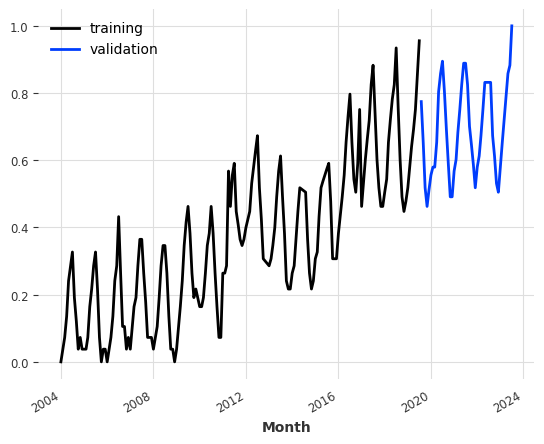

In [ ]:
train, val = (scaled_ts).split_before(0.8)# (we standardize by dividing by 100 since Google Trends data tops out at 100 by default!)
train.plot(label="training")
val.plot(label="validation")

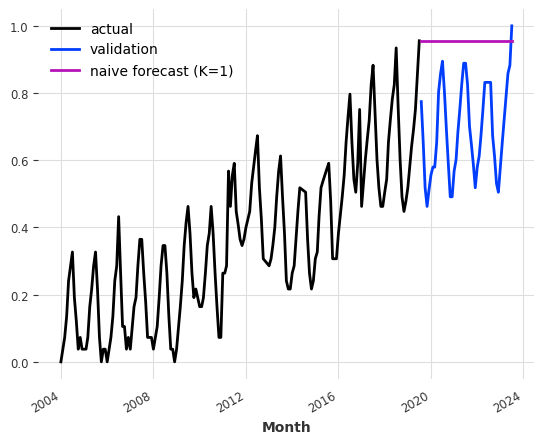

In [ ]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

train.plot(label="actual")
val.plot(label = "validation")
naive_forecast.plot(label="naive forecast (K=1)")

In [ ]:
from darts.metrics import mape

accuracy = mape(val, naive_forecast)
print(f"Mean Absolute Percentage Error: {accuracy}")

Mean Absolute Percentage Error: 44.1184868200106


In [ ]:
from darts.models import ExponentialSmoothing

# Initialize and fit an Exponential Smoothing model
model = ExponentialSmoothing()
model.fit(train)

# Generate forecasts
exp_forecast = model.predict(len(val))


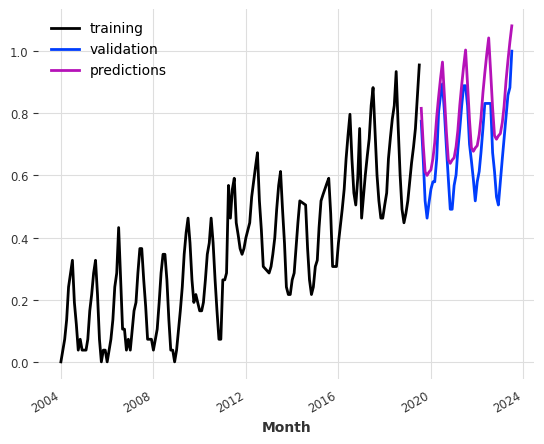

In [ ]:
train.plot(label="training")
val.plot(label="validation")
exp_forecast.plot(label = "predictions")

In [ ]:
from darts.metrics import mape

accuracy = mape(val, exp_forecast)
print(f"Mean Absolute Percentage Error: {accuracy}")

Mean Absolute Percentage Error: 16.13647623029156


Already quite a bit better!

### Multiple models

In [ ]:
from darts.models import AutoARIMA, Prophet, TBATS

results_dict = {}

for model in [AutoARIMA, Prophet, TBATS]:
    temp = model()
    temp.fit(train)
    preds = temp.predict(len(val))
    accuracy = mape(val, preds)
    results_dict[f"{model}"] = accuracy

10:01:54 - cmdstanpy - INFO - Chain [1] start processing
10:01:54 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
results_dict

{"<class 'darts.models.forecasting.auto_arima.AutoARIMA'>": 20.04339065033156,
 "<class 'darts.models.forecasting.prophet_model.Prophet'>": 16.76503823743529,
 "<class 'darts.models.forecasting.tbats_model.TBATS'>": 6.523111770534111}

### Covariates

In [ ]:
weather_df = pd.read_csv("weather.csv", header = 1)

In [ ]:
weather_df

Month  hot weather: (United States)
0    2004-01                            11
1    2004-02                             8
2    2004-03                            11
3    2004-04                            10
4    2004-05                            12
..       ...                           ...
230  2023-03                            44
231  2023-04                            46
232  2023-05                            50
233  2023-06                            61
234  2023-07                           100

[235 rows x 2 columns]

In [ ]:
weather_ts = TimeSeries.from_dataframe(weather_df, time_col="Month", value_cols="hot weather: (United States)")

Let's visualize the two side by side to see if they look aligned:

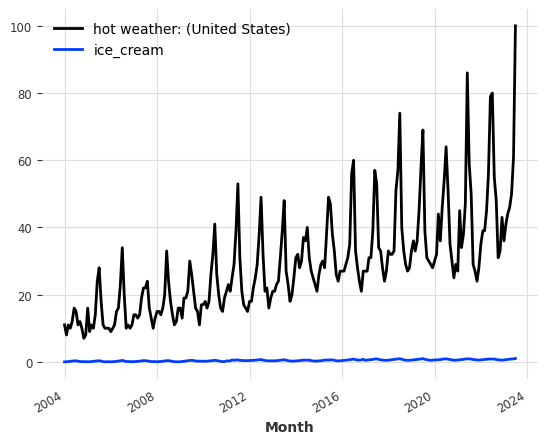

In [ ]:
weather_ts.plot()
scaled_ts.plot()

In [ ]:
preproc_weather = ts_transformer.fit_transform(weather_ts)

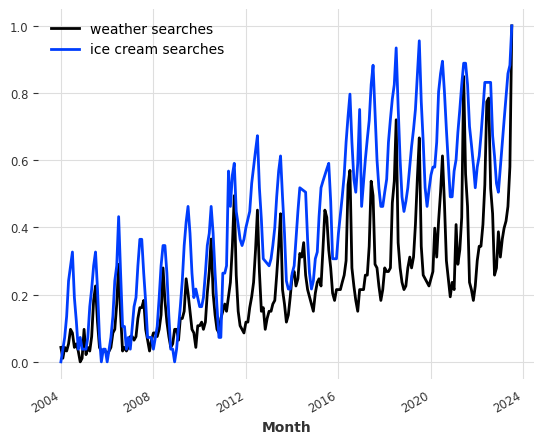

In [ ]:
preproc_weather.plot(label = "weather searches")
scaled_ts.plot(label = "ice cream searches")

In [ ]:
model = AutoARIMA()

# w no covariates
model.fit(train)
# predict on our val
base_preds = model.predict(len(val))
# calculate mape
accuracy = mape(val, base_preds)
# add it to a comparison dict
covariates_dict = {}
covariates_dict["no_covariates"] = accuracy

In [ ]:
covariate_model = AutoARIMA()
# w future covariates only
covariate_model.fit(train, future_covariates = preproc_weather)
base_preds = covariate_model.predict(len(val), future_covariates=preproc_weather)
accuracy = mape(val, base_preds)
covariates_dict[f"future_covariates"] = accuracy

In [ ]:
covariates_dict

{'no_covariates': 20.04339065033156, 'future_covariates': 5.49508164570306}